## Flights with a focus on India

Our team of elite Data Scientists is focusing on analyzing Commercial Airflight data within India, utilizing datasets that encompass airline operations, airplane models, airport locations, and flight routes. This initiative aims to enhance the understanding and efficiency of India's aviation sector through Python tools designed to map airports across the country, analyze flight distances and routes, and compare the usage of different airplane models. By concentrating on the wealth of data available, we are positioned to uncover insights into operational patterns, connectivity, and fleet utilization across India's diverse and rapidly growing aviation market. This comprehensive analysis is geared towards identifying opportunities for optimization and growth, shedding light on the complexities of air travel in India with a specific emphasis on sustainability. With the aim of contributing to a more informed and efficient aviation industry, our work seeks to pave the way for advancements in air travel management and strategic planning in India.

In [1]:
from Functions.air_traffic_data import AirTrafficData 

In [2]:
india_env = AirTrafficData()

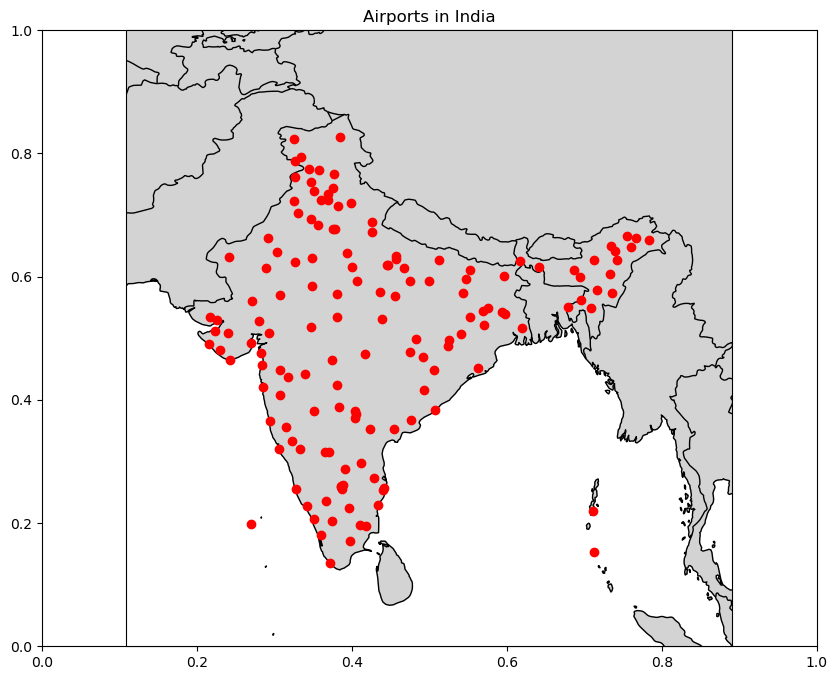

In [3]:
india_env.plot_airports_by_country("India")

The image displays a map of India with numerous red dots scattered throughout the country representing the locations of airports. The distribution of the airports is widespread, covering the northern regions, central areas, the southern tip, as well as the eastern and western parts of India. There appears to be a relatively even spread of airports across the mainland, with varying concentrations. Some regions, such as the central part, show a denser clustering of dots, whereas other areas, especially towards the edges of the country, have more sparsely placed dots. There are also a few dots representing airports on the islands to the southeast and southwest of the mainland.    

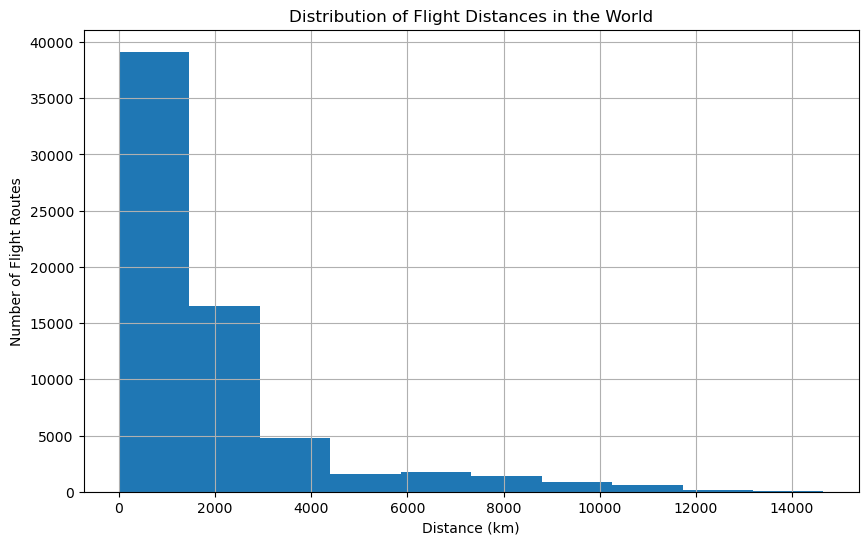

In [4]:
india_env.distance_analysis()

The histogram in the image illustrates the distribution of flight distances for routes worldwide. The x-axis represents the distance of flight routes in kilometers, while the y-axis shows the number of flight routes. 
A significant number of flights cover distances of less than 2000 kilometers, as indicated by the first bar being the tallest. The number of flight routes then sharply decreases as the distance increases, showing that long-haul flights (distances greater than 2000 kilometers) are less frequent.

The concentration of short-haul flights suggests that a large portion of air travel is over distances that could potentially be covered by alternative modes of transport, such as high-speed trains, which are often more sustainable in terms of carbon footprint per passenger-kilometer. In regions where high-speed rail infrastructure is well-developed, such as in parts of Europe and East Asia, trains have been a popular substitute for short-haul flights due to their competitive travel times, convenience, and lower environmental impact.

Expanding transportation infrastructure to support high-speed trains or other eco-friendly travel options could potentially alleviate some of the pressures of air travel, such as airport congestion, air traffic control, and aviation emissions.

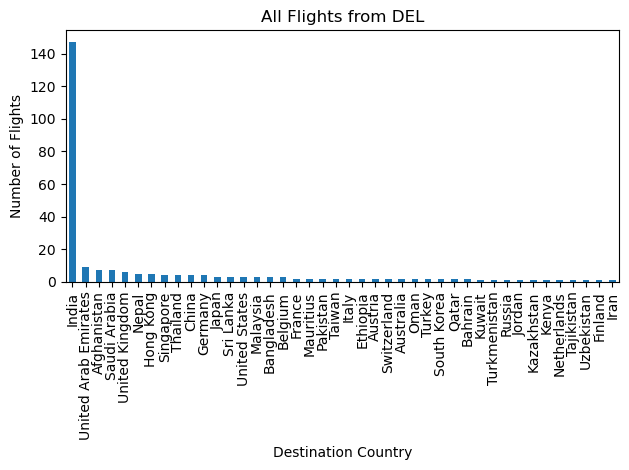

In [5]:
india_env.flights_from_airport("DEL")

In [6]:
AirTrafficData().airport_info('Indira Gandhi International Airport')

| Aspect                 | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| Location               | New Delhi, India                                                            |
| Size                   | Spread over an area of 5,106 acres                                          |
| Terminals              | 3 terminals - Terminal 1, Terminal 2, Terminal 3                           |
| Runways                | 3 runways - 10,500 ft, 12,500 ft, 14,500 ft                                |
| Airlines               | Served by over 80 airlines                                                  |
| Destinations           | Direct flights to over 200 destinations worldwide                           |
| Passenger Traffic      | Handles over 69 million passengers annually                                |
| Cargo Traffic          | Handles over 1 million metric tonnes of cargo annually                      |
| Facilities             | Duty-free shops, lounges, restaurants, medical facilities, car rental       |
| Parking                | Short-term and long-term parking options available                         |
| Transportation         | Metro, buses, taxis, and car rental services available for passengers        |
| Security               | Advanced security measures in place for passenger safety                    |
| Services               | VIP lounges, baggage handling, wheelchair assistance, lost and found         |

Delhi Airport, a major aviation hub located in New Delhi, India, boasts a sprawling expanse of 5,106 acres and is equipped with three terminals and runways, catering to over 100 airlines and managing an impressive annual passenger capacity of over 70 million. The airport's significant infrastructure is reflected in its high volume of domestic flights, as evidenced by a bar chart indicating that the majority of flights from Delhi serve other destinations within India, highlighting the crucial role air travel plays in bridging vast distances across the country. Additionally, the airport's considerable number of flights to the United Arab Emirates and Afghanistan underscores its importance in international connectivity, aligning with its robust facilities and transportation options that ensure a comprehensive and accessible travel experience for both domestic and international passengers.

Several opportunities for optimization and growth emerge, particularly when considering sustainability:

1. **Domestic Travel Optimization**: The high frequency of domestic flights suggests that there's room for enhancing the efficiency of flight schedules, perhaps through improved route planning, to reduce congestion and fuel consumption. Additionally, optimizing aircraft utilization to ensure that flights are maximally booked can reduce the number of flights needed.

2. **Alternative Transportation**: Given the heavy reliance on air travel for domestic routes under 2000 km, there’s potential for developing alternative, more sustainable ground transportation. Investments in high-speed rail could alleviate air traffic, reduce carbon emissions, and provide efficient connectivity.

4. **Airport Operations**: The expansive infrastructure of Delhi Airport, with its three terminals and runways, indicates room for implementing energy-saving measures within the airport itself, such as solar power usage and green buildings, contributing to a reduction in overall carbon emissions.

7. **International Hubs and Spokes**: For international connectivity, especially to the UAE and Afghanistan, there’s an opportunity to analyze the passenger and cargo flows to optimize these routes, possibly consolidating flights or coordinating with other airlines to maximize efficiency and reduce duplicate services.


In [7]:
india_env.most_used_airplane_models(3, country="India")

Name
Canadair Challenger    31
dtype: int64

In [8]:
india_env.aircraft_info("Canadair Challenger")

| Aspect              | Specification        |
|---------------------|----------------------|
| Manufacturer        | Canadair             |
| Model               | Challenger           |
| Type                | Business jet         |
| Crew                | 2                    |
| Capacity            | 9-19 passengers      |
| Length              | 68 ft 7 in (20.9 m)  |
| Wingspan            | 64 ft 4 in (19.6 m)  |
| Height              | 20 ft 5 in (6.2 m)   |
| Maximum speed       | Mach 0.82 (541 kn)   |
| Range               | 3,056 nmi (5,657 km) |
| Engines             | 2 x General Electric CF34-3A1 turbofans |
| First flight        | November 8, 1978     |
| Introduced          | 1980                 |
| Status              | Active               |

The table details the specifications of a Canadair Challenger, which is a business jet type aircraft. According to the data, this model seems to be the only one being utilized within India, which is quite unusual considering the vast and diverse requirements of commercial air travel. Typically, a range of aircraft types are employed to cater to different route lengths, passenger capacities, and operational efficiencies. The Challenger’s capacity for up to 19 passengers suggests it’s used for either private, business, or small-scale commercial flights.

This anomaly could be explained by the elevated number of missing "IATA code" values in the dataset, implying that it may not be adequately representing the full spectrum of aircraft in use throughout India. IATA codes are essential for tracking, scheduling, and aviation logistics, and their absence indicates significant gaps in the dataset. This lack of complete data could hinder accurate analysis and strategic planning in the aviation sector.

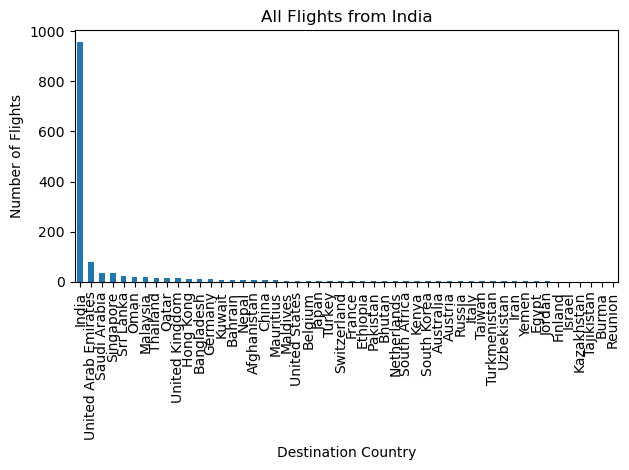

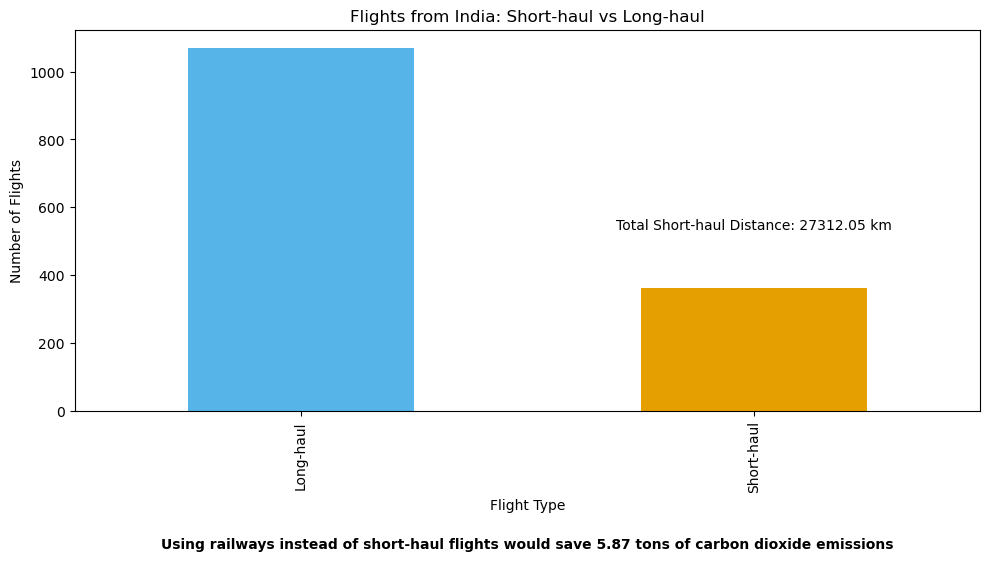

In [9]:
india_env.flights_from_country('India', cutoff_distance=500)

The data indicates a dominant pattern of domestic flights within India, consistent with previous observations, and highlights the United Arab Emirates and Saudi Arabia as the next most frequent international flight destinations from India. This trend aligns with the flight patterns observed specifically for Delhi, suggesting that the capital's airport serves as a microcosm for the country's broader aviation trends.

The bar chart further underlines the prevalence of short-haul flights within the country, which represent a significant portion of India's overall flight operations. The comparison between short-haul and long-haul flights illustrates the potential for a modal shift in transportation. By transitioning from air to rail for short-haul journeys, particularly those under 500 kilometers, there is an opportunity to substantially reduce carbon dioxide emissions by an estimated 5.87 tons. This shift not only offers environmental benefits through lower emissions but also may relieve congestion in airspace and at airports, and improve operational efficiencies.

-------

**Sources**

https://www.statista.com/statistics/1185559/carbon-footprint-of-travel-per-kilometer-by-mode-of-transport/#:~:text=The%20carbon%20footprint%20of%20a%20domestic%20flight%20

- 255 grams of carbon dioxide on short-haul flight (<1000 km)
- 40 grams of carbon dioxide on the railway